<a href="https://colab.research.google.com/github/Sang565/Parking-prediction-using-DNN-or-LSTM-models/blob/main/LSTM_16_8_8_model_for_ParkingPrediction.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Parking prediction using Deep LSTM-based model

Running parking occupancy prediction with **our simulated dataset**, instead of the real Birmingham parking dataset

Dataset link: 
+ Our simulated dataset: https://archive.org/download/simulated-parking-datasets/dataset-20200501_20200731.csv

# Import libraries

In [ ]:
import pandas as pd
import matplotlib as mpl
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler, StandardScaler
                                                            
from tensorflow.python.keras.preprocessing.sequence import TimeseriesGenerator  #must use this one for training with TimeSeriesGenerator 
import tensorflow as tf 

# Part 1. Data Pre-processing

# Read dataset

Read dataset and convert to pandas dataFrame

In [ ]:
#df = pd.read_csv('/content/dataset-20200501_20200731.csv')   # via the file downloaded
df = pd.read_csv('https://archive.org/download/simulated-parking-datasets/dataset-20200501_20200731.csv')  # our simulated dataset

In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 243104 entries, 0 to 243103
Data columns (total 3 columns):
 #   Column            Non-Null Count   Dtype 
---  ------            --------------   ----- 
 0   LastUpdated       243104 non-null  object
 1   SystemCodeNumber  243104 non-null  int64 
 2   Occupancy         243104 non-null  int64 
dtypes: int64(2), object(1)
memory usage: 5.6+ MB


In [ ]:
df.shape

(243104, 3)

In [ ]:
df.head()

,LastUpdated,SystemCodeNumber,Occupancy
0,2020-05-01T00:00:15.000+12:00,1,102
1,2020-05-01T00:00:15.000+12:00,2,188
2,2020-05-01T00:01:15.000+12:00,1,108
3,2020-05-01T00:01:15.000+12:00,2,165
4,2020-05-01T00:02:15.000+12:00,1,106


In [ ]:
df  # dataset exploration

,LastUpdated,SystemCodeNumber,Occupancy
0,2020-05-01T00:00:15.000+12:00,1,102
1,2020-05-01T00:00:15.000+12:00,2,188
2,2020-05-01T00:01:15.000+12:00,1,108
3,2020-05-01T00:01:15.000+12:00,2,165
4,2020-05-01T00:02:15.000+12:00,1,106
...,...,...,...
243099,2020-07-31T23:55:15.000+12:00,1,101
243100,2020-07-31T23:56:15.000+12:00,1,101
243101,2020-07-31T23:57:15.000+12:00,1,111
243102,2020-07-31T23:58:15.000+12:00,1,100


Dataset infos:
- Collected from 01/05/2020 to 31/07/2020

- 2 different carparks (CP)

- Update time inverval is 1 minute

- Total no. of records: 336,990


**Some attribute information: **

SystemCodeNumber: carpark ID

Occupancy: CP occupancy

LastUpdated: record update time


In [ ]:
df.LastUpdated.head()

0    2020-05-01T00:00:15.000+12:00
1    2020-05-01T00:00:15.000+12:00
2    2020-05-01T00:01:15.000+12:00
3    2020-05-01T00:01:15.000+12:00
4    2020-05-01T00:02:15.000+12:00
Name: LastUpdated, dtype: object

Convert date format from object type to datetime64 type to apply training and prediction

In [ ]:
# filter to eliminate one timezone (which has less data) for to_datetime() funtion use
#df[df['LastUpdated'].str.contains('+12:00', regex=False)]

In [ ]:
# --- just run with the a half amount of data (121552 of 243104 records in total) 
#     --> saving training time, but the result still better than the DNN model -------
df = df[0:121551] # try with the first 121,552 records for saving training time

In [ ]:
# add column 'date' by converting column 'LastUpdated' into datetime64 format
df['date'] = pd.to_datetime(df['LastUpdated'], infer_datetime_format=True)  # Note: to_datetime() cannot convert if there are 2 different timezones (e.g. +13:00 and +12:00) 
                                                                                    #in the dataset --> filter before to select the +12:00

# use this one for faster process if the 'LastUpdated' is already in Timestamp (datetime) format
#df['date'] = df['LastUpdated']

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 121551 entries, 0 to 121550
Data columns (total 4 columns):
 #   Column            Non-Null Count   Dtype                                
---  ------            --------------   -----                                
 0   LastUpdated       121551 non-null  object                               
 1   SystemCodeNumber  121551 non-null  int64                                
 2   Occupancy         121551 non-null  int64                                
 3   date              121551 non-null  datetime64[ns, pytz.FixedOffset(720)]
dtypes: datetime64[ns, pytz.FixedOffset(720)](1), int64(2), object(1)
memory usage: 3.7+ MB


In [ ]:
df.date.head()

0   2020-05-01 00:00:15+12:00
1   2020-05-01 00:00:15+12:00
2   2020-05-01 00:01:15+12:00
3   2020-05-01 00:01:15+12:00
4   2020-05-01 00:02:15+12:00
Name: date, dtype: datetime64[ns, pytz.FixedOffset(720)]

**------------ Select a specific CP to do prediction ----------**


In [ ]:
#df.SystemCodeNumber.head()

In [ ]:
# convert CP_ID column from Int to String
df['SystemCodeNumber'] = df['SystemCodeNumber'].apply(str)   # https://datatofish.com/integers-to-strings-dataframe/

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


In [ ]:
# 2 CPs: 1 and 2 

# Select the target CP 
df_cp_filtered = df[df['SystemCodeNumber'].str.match('1')]

df_cp_filtered

,LastUpdated,SystemCodeNumber,Occupancy,date
0,2020-05-01T00:00:15.000+12:00,1,102,2020-05-01 00:00:15+12:00
2,2020-05-01T00:01:15.000+12:00,1,108,2020-05-01 00:01:15+12:00
4,2020-05-01T00:02:15.000+12:00,1,106,2020-05-01 00:02:15+12:00
6,2020-05-01T00:03:15.000+12:00,1,93,2020-05-01 00:03:15+12:00
8,2020-05-01T00:04:15.000+12:00,1,117,2020-05-01 00:04:15+12:00
...,...,...,...,...
121542,2020-06-14T02:13:15.000+12:00,1,110,2020-06-14 02:13:15+12:00
121544,2020-06-14T02:14:15.000+12:00,1,101,2020-06-14 02:14:15+12:00
121546,2020-06-14T02:15:15.000+12:00,1,108,2020-06-14 02:15:15+12:00
121548,2020-06-14T02:16:15.000+12:00,1,102,2020-06-14 02:16:15+12:00


In [ ]:
# df_cp_filtered

In [ ]:
df_cp_filtered.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 63472 entries, 0 to 121550
Data columns (total 4 columns):
 #   Column            Non-Null Count  Dtype                                
---  ------            --------------  -----                                
 0   LastUpdated       63472 non-null  object                               
 1   SystemCodeNumber  63472 non-null  object                               
 2   Occupancy         63472 non-null  int64                                
 3   date              63472 non-null  datetime64[ns, pytz.FixedOffset(720)]
dtypes: datetime64[ns, pytz.FixedOffset(720)](1), int64(1), object(2)
memory usage: 2.4+ MB


Set index column and select features

array([<matplotlib.axes._subplots.AxesSubplot object at 0x7fa0a35bf150>],
      dtype=object)

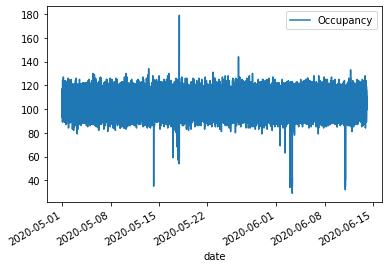

In [ ]:
# Set index (use date column) and select features and do plotting for viewing
df_cp_filtered.set_index('date') [['Occupancy']].plot(subplots=True)  # 2 steps: select column works as index,  and plot selected column (not the index column)


# Data quality checking and pre-processing

In [ ]:
# pre-processing data --> drop the faulted records
df_cp_filtered.query('Occupancy < 80')  

,LastUpdated,SystemCodeNumber,Occupancy,date
6196,2020-05-03T03:53:15.000+12:00,1,79,2020-05-03 03:53:15+12:00
38018,2020-05-14T06:00:15.000+12:00,1,35,2020-05-14 06:00:15+12:00
46030,2020-05-17T00:57:15.000+12:00,1,63,2020-05-17 00:57:15+12:00
46032,2020-05-17T00:58:15.000+12:00,1,64,2020-05-17 00:58:15+12:00
46034,2020-05-17T00:59:15.000+12:00,1,66,2020-05-17 00:59:15+12:00
...,...,...,...,...
112726,2020-06-11T00:32:15.000+12:00,1,38,2020-06-11 00:32:15+12:00
112727,2020-06-11T00:33:15.000+12:00,1,46,2020-06-11 00:33:15+12:00
112728,2020-06-11T00:34:15.000+12:00,1,35,2020-06-11 00:34:15+12:00
112729,2020-06-11T00:35:15.000+12:00,1,40,2020-06-11 00:35:15+12:00


In [ ]:
df_cp_filtered.query('Occupancy > 125')  

,LastUpdated,SystemCodeNumber,Occupancy,date
475,2020-05-01T03:57:15.000+12:00,1,127,2020-05-01 03:57:15+12:00
2436,2020-05-01T20:18:15.000+12:00,1,126,2020-05-01 20:18:15+12:00
5822,2020-05-03T00:46:15.000+12:00,1,126,2020-05-03 00:46:15+12:00
12764,2020-05-05T10:39:15.000+12:00,1,130,2020-05-05 10:39:15+12:00
13394,2020-05-05T15:54:15.000+12:00,1,129,2020-05-05 15:54:15+12:00
13912,2020-05-05T20:13:15.000+12:00,1,126,2020-05-05 20:13:15+12:00
15648,2020-05-06T10:41:15.000+12:00,1,126,2020-05-06 10:41:15+12:00
15945,2020-05-06T13:09:15.000+12:00,1,127,2020-05-06 13:09:15+12:00
16096,2020-05-06T14:25:15.000+12:00,1,126,2020-05-06 14:25:15+12:00
19922,2020-05-07T22:25:15.000+12:00,1,126,2020-05-07 22:25:15+12:00


In [ ]:
df_cp_filtered = df_cp_filtered.drop(df_cp_filtered[df_cp_filtered.Occupancy < 80].index) 

In [ ]:
df_cp_filtered = df_cp_filtered.drop(df_cp_filtered[df_cp_filtered.Occupancy > 125].index)

array([<matplotlib.axes._subplots.AxesSubplot object at 0x7fa0a31c6750>],
      dtype=object)

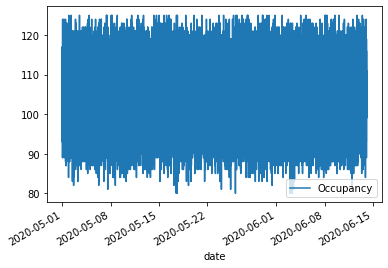

In [ ]:
df_cp_filtered.set_index('date') [['Occupancy']].plot(subplots=True)

In [ ]:
# Select final input feature ('Occupany')
df_input = df_cp_filtered[['Occupancy']]  # df_input also use 'date' for index, inherited from df
df_input.head()

,Occupancy
0,102
2,108
4,106
6,93
8,117


In [ ]:
df_input.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 63217 entries, 0 to 121550
Data columns (total 1 columns):
 #   Column     Non-Null Count  Dtype
---  ------     --------------  -----
 0   Occupancy  63217 non-null  int64
dtypes: int64(1)
memory usage: 987.8 KB


In [ ]:
# check the distribution of input features
df_input.describe()

,Occupancy
count,63217.000000
mean,105.017163
std,6.592817
min,80.000000
25%,101.000000
50%,105.000000
75%,109.000000
max,125.000000


# Data sclaling to [0, 1] range

In [ ]:
scaler = MinMaxScaler()
data_scaled = scaler.fit_transform(df_input)

In [ ]:
data_scaled

array([[0.48888889],
       [0.62222222],
       [0.57777778],
       ...,
       [0.62222222],
       [0.48888889],
       [0.55555556]])

In [ ]:
data_scaled.shape

(63217, 1)

# Features (Inputs) and Target (Output prediction) selections 

In [ ]:
# Feature selection and Target predicted selection 
features = data_scaled  # use for input 

target = data_scaled[:,0] # use for output prediction

In [ ]:
target

array([0.48888889, 0.62222222, 0.57777778, ..., 0.62222222, 0.48888889,
       0.55555556])

In [ ]:
target.shape  # (19735,) --> one column by default

(63217,)

# Generate x_train/x_test --> train_generator and test_generator data
  --> to transfer from dealing with **timeseries prediction** problem to **supervised learning** problem
 

In [ ]:
# create x_train, x_test, y_train, and y_test
# 80% for training, 20% for testing and evaluation
x_train, x_test, y_train, y_test = train_test_split(features, target, test_size=0.20, random_state=123, shuffle=False) # remember to set shuffle=False --> important for TS prediction


In [ ]:
x_train.shape # 80%

(50573, 1)

In [ ]:
y_train.shape

(50573,)

In [ ]:
x_test.shape

(12644, 1)

Create a data structure with 10,080 (60x24hx7days) timestamps of inputs (1 week data of each CP) --> to create 1 output

For example, taking every group of 10,080 records (or 1-week data) to work as **x_train_generators** to create one sigle future record of **y_train_generator** since it does not exist in the dataset

In [ ]:
# Create a data structure with 10,080 timestamps of inputs --> to create 1 output
# using TimeSeriesGenerator() function
window_length=10080 # 1-week length: 10,080 
batch_size=128   # batch_size: Integer or None. Number of samples per gradient update. If unspecified, batch_size will default to 32.

train_generator = TimeseriesGenerator(x_train, y_train, length=window_length, sampling_rate=1, batch_size=batch_size)
test_generator = TimeseriesGenerator(x_test, y_test, length=window_length, sampling_rate=1, batch_size=batch_size)

In [ ]:
train_generator[0]  # -- #batch_size groups of an array of 10,080 arrays of x_train, and and an array of #batch_size values of y_train
                    # Or 10,080 [0:10079] input records (rows) --> create one output record (i.e. the value of record 10,080)

(array([[[0.48888889],
         [0.62222222],
         [0.57777778],
         ...,
         [0.53333333],
         [0.57777778],
         [0.77777778]],
 
        [[0.62222222],
         [0.57777778],
         [0.28888889],
         ...,
         [0.57777778],
         [0.77777778],
         [0.62222222]],
 
        [[0.57777778],
         [0.28888889],
         [0.82222222],
         ...,
         [0.77777778],
         [0.62222222],
         [0.48888889]],
 
        ...,
 
        [[0.35555556],
         [0.53333333],
         [0.44444444],
         ...,
         [0.66666667],
         [0.42222222],
         [0.71111111]],
 
        [[0.53333333],
         [0.44444444],
         [0.46666667],
         ...,
         [0.42222222],
         [0.71111111],
         [0.33333333]],
 
        [[0.44444444],
         [0.46666667],
         [0.48888889],
         ...,
         [0.71111111],
         [0.33333333],
         [0.62222222]]]),
 array([0.62222222, 0.48888889, 0.37777778, 0.62222222,

In [ ]:
# checking 
x_train[10080]  # -->  equal to the first value in train_generator[0] array

array([0.62222222])

# Part 2. Create a model (LSTM-based) 

In [ ]:
# Initializing the Neural Network 
model = tf.keras.Sequential()

# Adding 1st LSTM layer
#window_length=10080
model.add(tf.keras.layers.LSTM(16, input_shape=(window_length, 1), return_sequences=True))

# Adding 2nd LSTM layer
model.add(tf.keras.layers.LSTM(8, return_sequences=True))
model.add(tf.keras.layers.Dropout(0.2)) 

# Adding 3rd LSTM layer
model.add(tf.keras.layers.LSTM(8, return_sequences=False))
model.add(tf.keras.layers.Dropout(0.2)) 

# Output layer
model.add(tf.keras.layers.Dense(1))

In [ ]:
# check the layers' attributes of the model
model.layers

In [ ]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm (LSTM)                  (None, 10080, 16)         1152      
_________________________________________________________________
lstm_1 (LSTM)                (None, 10080, 8)          800       
_________________________________________________________________
dropout (Dropout)            (None, 10080, 8)          0         
_________________________________________________________________
lstm_2 (LSTM)                (None, 8)                 544       
_________________________________________________________________
dropout_1 (Dropout)          (None, 8)                 0         
_________________________________________________________________
dense (Dense)                (None, 1)                 9         
Total params: 2,505
Trainable params: 2,505
Non-trainable params: 0
______________________________________________________

# Part 3. Train the model

Using TensorBoard (optional)

In [ ]:
tb = tf.keras.callbacks.TensorBoard(log_dir='logs',histogram_freq=1) 

Configure: Checking and monitoring

In [ ]:
#---- Configure: checking and monitoring ---------------------
#early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=50, mode='min') # 
early_stopping = tf.keras.callbacks.EarlyStopping(monitor='mean_absolute_error', patience=3, mode='min') # USing

#---- Save model option ------------------------
#model_checkpoint = tf.keras.callbacks.ModelCheckpoint(filepath='weights.h5', monitor='val_loss', verbose=1, save_best_only=True, save_weights_only=True) # not USE
#model_checkpoint = tf.keras.callbacks.ModelCheckpoint(filepath='weights.h5', monitor='mean_absolute_error', verbose=1, save_best_only=True, save_weights_only=True)  # USing
model_checkpoint = tf.keras.callbacks.ModelCheckpoint(filepath='model.h5', monitor='mean_absolute_error', verbose=1, save_best_only=True)  # USing: save the whole model


In [ ]:
#test_generator[0]

Compile and Train the model

In [ ]:
#----- Compiling the Neural Network
model.compile(#loss=tf.losses.MeanSquaredError(), # Error when deploying the model in DL4J --> use the below instead (https://github.com/eclipse/deeplearning4j/issues/8990)
              loss='mean_squared_error',
              optimizer=tf.optimizers.Adam(),   # use Adam optimizer
              metrics=[tf.metrics.MeanAbsoluteError()])   

# Start training   
history = model.fit( 
                    train_generator, 
                    epochs=50, #1000                            
                    validation_data=test_generator, # for model validation                     
                    shuffle=False,
                    verbose=1,                    
                    callbacks=[early_stopping, model_checkpoint, tb]  # for model saving and Tensorboard
                    #callbacks=[early_stopping, tb]     # for Tensorboard
                    #callbacks=[early_stopping]  # for faster running without model saving and tb     
                    )

Epoch 1/50
317/317 [==============================] - 277s 765ms/step - loss: 0.0839 - mean_absolute_error: 0.2233 - val_loss: 0.0220 - val_mean_absolute_error: 0.1185

Epoch 00001: mean_absolute_error improved from inf to 0.16504, saving model to model.h5
Epoch 2/50
317/317 [==============================] - 235s 740ms/step - loss: 0.0292 - mean_absolute_error: 0.1363 - val_loss: 0.0220 - val_mean_absolute_error: 0.1186

Epoch 00002: mean_absolute_error improved from 0.16504 to 0.13537, saving model to model.h5
Epoch 3/50
317/317 [==============================] - 235s 741ms/step - loss: 0.0273 - mean_absolute_error: 0.1321 - val_loss: 0.0220 - val_mean_absolute_error: 0.1185

Epoch 00003: mean_absolute_error improved from 0.13537 to 0.13056, saving model to model.h5
Epoch 4/50
317/317 [==============================] - 235s 741ms/step - loss: 0.0255 - mean_absolute_error: 0.1275 - val_loss: 0.0220 - val_mean_absolute_error: 0.1184

Epoch 00004: mean_absolute_error improved from 0.130

Invoke Tensorboard

In [ ]:
# Load the TensorBoard notebook extension 
# https://stackoverflow.com/questions/55970686/tensorboard-not-found-as-magic-function-in-jupyter

%load_ext tensorboard

In [ ]:
%tensorboard --logdir logs

# Part 4. Model evaluation

In [ ]:
model.evaluate(test_generator, verbose=1)   # better to use different test_generator and validate_generator data for model evaluate and validation purposes
                                            #    in this case, we are using the same test_generator data
                                            # results: val_loss, val_MAE

21/21 [==============================] - 7s 345ms/step - loss: 0.0220 - mean_absolute_error: 0.1186


[0.02200373262166977, 0.11855580657720566]

# Part 5. Model inference (Prediction )

Do Prediction

In [ ]:
predictions = model.predict(test_generator)

In [ ]:
#predictions[0:19]

In [ ]:
predictions.shape

(2564, 1)

# Part 6. Present the prediction results using graph

Inverse Transform

In [ ]:
df_pred_rev = scaler.inverse_transform(predictions)

Append columns into the current DataFrame for better presentation

In [ ]:
df_input.shape

(63217, 1)

In [ ]:
df_final = df_input[predictions.shape[0]*-1:].copy()  # *-1: go up from the last 
                                                      # select from the last row and go up to the row number (=predictions.shape[0]=16,406)
                                                       # ==> which is reserved for actual data   


In [ ]:
df_final.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2564 entries, 116422 to 121550
Data columns (total 1 columns):
 #   Column     Non-Null Count  Dtype
---  ------     --------------  -----
 0   Occupancy  2564 non-null   int64
dtypes: int64(1)
memory usage: 40.1 KB


In [ ]:
df_final.shape

(2564, 1)

In [ ]:
# change column name from 'Occupancy' to 'Occ_Actual'
df_final.columns = ['Occ_Actual']

In [ ]:
df_final.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2564 entries, 116422 to 121550
Data columns (total 1 columns):
 #   Column      Non-Null Count  Dtype
---  ------      --------------  -----
 0   Occ_Actual  2564 non-null   int64
dtypes: int64(1)
memory usage: 40.1 KB


Add one more column (named 'Occ_Predicted') into the final dataFrame 


In [ ]:
df_final['Occ_Predicted'] = df_pred_rev[:,0] # append one more column (named 'Occ_Predicted') into df_final 


In [ ]:
df_final.head()

,Occ_Actual,Occ_Predicted
116422,116,104.893799
116424,111,104.895447
116426,114,104.897911
116428,106,104.900764
116431,103,104.901901
